# Plots for Content Africa study

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pandas as pd

def removeOutliers(arr):
    elements = np.array(arr)
    elements = elements.astype(int)
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    
    final_list = [x for x in arr if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
        
    return final_list


DATA_PATH="../data/tables/views/"

mobile = []
price_mobile = []
desktop = []
price_desktop = []
with open(DATA_PATH+"domain_cost_view.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        size_m = row[3]
        size_d = row[5]
        price_m = row[4]
        price_d = row[6]
        
        if (price_m == "NULL" or price_d == "NULL"):
            continue
        
        mobile.append(int(size_m)/1000)
        desktop.append(int(size_d)/1000)
        
        try:
            price_mobile.append(float(price_m))
            price_desktop.append(float(price_d))
        except:
            print price_m
            print price_d
        

## Size and price of African websites

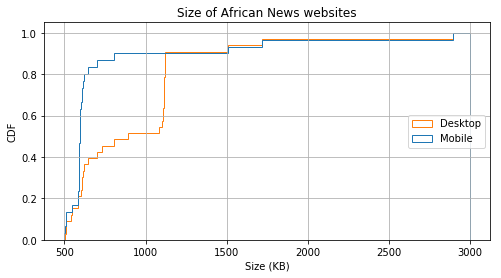

In [2]:
n_bins = 500

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([mobile, desktop], n_bins, normed=1, histtype='step', range=[500, 3000], 
                           cumulative=True, label=['Mobile', 'Desktop'])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Size of African News websites')
ax.set_xlabel('Size (KB)')
ax.set_ylabel('CDF')

#plt.savefig("../data/plots/website_sizes.svg")
plt.show()

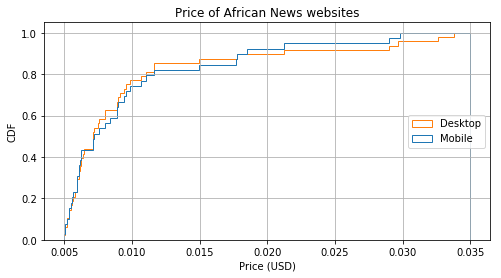

In [3]:
n_bins = 500

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([price_mobile, price_desktop], n_bins, normed=1, histtype='step', range=[0.005, 0.035], 
                           cumulative=True, label=['Mobile', 'Desktop'])
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Price of African News websites')
ax.set_xlabel('Price (USD)')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/website_price_to_access.svg")
plt.show()

## Barcharts exploring local vs remote hosting

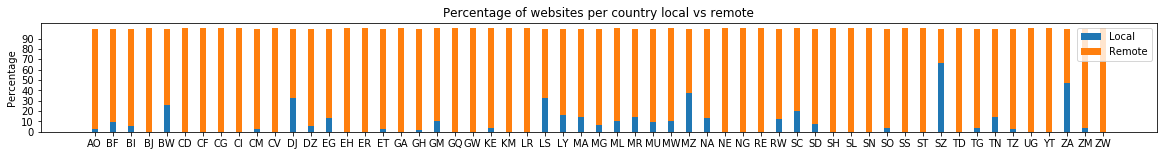

In [4]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
label_cc = []
data_local = []
data_remote = []
count = 0
with open(DATA_PATH+"view_remote_local_websites_count_view.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        cc = row[0]
        total = int(row[1])
        local = int(row[2])
        remote = int(row[3])
        
        label_cc.append(cc)
        data_local.append(100*local/total)
        data_remote.append(100*remote/total)
        count = count + 1
        
N = count

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


plt.figure(figsize=(20, 2))

p1 = plt.bar(ind, data_local, width)
p2 = plt.bar(ind, data_remote, width,
             bottom=data_local)


plt.ylabel('Percentage')
plt.title('Percentage of websites per country local vs remote')
plt.xticks(ind, label_cc)
plt.yticks(np.arange(0, 100, 10))
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))

plt.show()

## Preprocessing domain rtt values

In [6]:
remoteDict = {}
localDict = {}
medianRTT = {}
averageRTT = {}

with open(DATA_PATH+"domain_rtt_remote.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        cc3 = row[0]
        cc = row[1]
        domain = row[2]
        rtt = int(row[3])
        
        try:
            remoteDict[cc].append(rtt)
        except:
            rttArray = []
            rttArray.append(rtt)
            remoteDict[cc] = rttArray
            
with open(DATA_PATH+"domain_rtt_local.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        cc3 = row[0]
        cc = row[1]
        domain = row[2]
        rtt = int(row[3])
        
        try:
            localDict[cc].append(rtt)
        except:
            rttArray = []
            rttArray.append(rtt)
            localDict[cc] = rttArray

for cc in remoteDict.keys():
    try:
        medianLocalRTT = np.median(localDict[cc])
        medianRemoteRTT = np.median(remoteDict[cc])
        
        averageLocalRTT = np.average(localDict[cc])
        averageRemoteRTT = np.average(remoteDict[cc])
        
        medianRTT[cc] = [medianLocalRTT, medianRemoteRTT]
        averageRTT[cc] = [averageLocalRTT, averageRemoteRTT]
    except:
        medianRTT[cc] = [0, medianRemoteRTT]
        averageRTT[cc] = [0, averageRemoteRTT]

### Median RTT Distribution by country

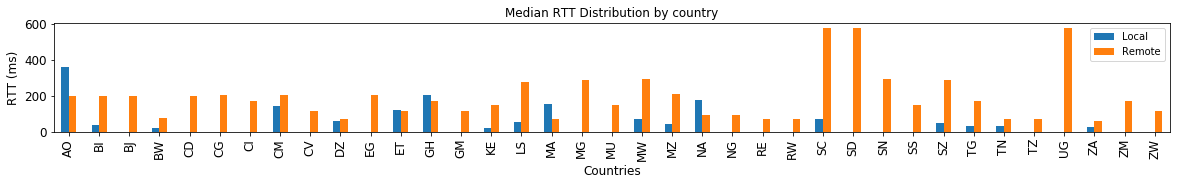

In [7]:
df = pd.DataFrame(data=medianRTT)
df = df.T

ax = df.plot(kind='bar', title ="Median RTT Distribution by country", figsize=(20, 2), legend=True, fontsize=12)
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("RTT (ms)", fontsize=12)
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))
plt.show()


### Average RTT Distribution by country

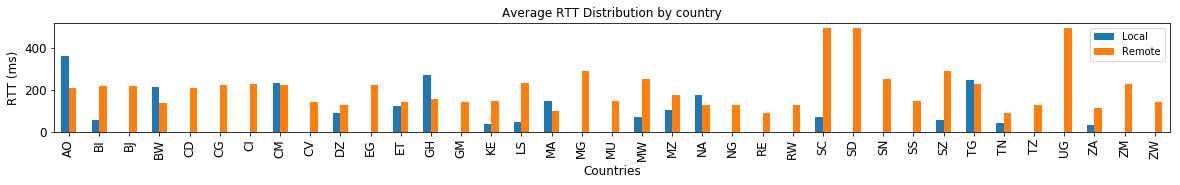

In [8]:
df = pd.DataFrame(data=averageRTT)
df = df.T

ax = df.plot(kind='bar', title ="Average RTT Distribution by country", figsize=(20, 2), legend=True, fontsize=12)
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("RTT (ms)", fontsize=12)
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))
plt.show()

# Africa Maps

In [11]:
import plotly.plotly as py
from plotly import tools

df_local = pd.read_csv(DATA_PATH+"domain_rtt_local.csv", usecols=[0,3])

df_local = df_local.groupby(['cc3'], as_index=False).median()

data = [dict(
        type='choropleth',
        autocolorscale = True,
        locations = df_local['cc3'],
        z = df_local['rtt'].astype(float),
        locationmode = 'ISO-3',
        text = df_local['rtt'],
        marker = dict(
            line = dict (
                width = 1
            ) ),
        colorbar = dict(
            title = "RTT (ms)",
            x = 0.7
            )
        )]

layout = dict(
        title = 'RTT to locally hosted news websites',
        geo = dict(
            scope='africa',
            projection=dict( type='mercator' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )



In [12]:
df_remote = pd.read_csv(DATA_PATH+"domain_rtt_remote.csv", usecols=[0,3])

df_remote = df_remote.groupby(['cc3'], as_index=False).median()

data = [dict(
        type='choropleth',
        autocolorscale = True,
        locations = df_remote['cc3'],
        z = df_remote['rtt'].astype(float),
        locationmode = 'ISO-3',
        text = df_remote['rtt'],
        marker = dict(
            line = dict (
                width = 1
            ) ),
        colorbar = dict(
            title = "RTT (ms)",
            x = 0.7
            )
        )]

layout = dict(
        title = 'RTT to remotely hosted news websites',
        geo = dict(
            scope='africa',
            projection=dict( type='mercator' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    

fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )
